In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import cholesky
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel
from scipy import exp, sqrt, log, heaviside
from scipy.interpolate import interp1d
from montecarlo import MC_Analisys,MC
from scipy.optimize import minimize
from targetvol import time_grid_union,time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy

### Two equities

#### market data

In [2]:
N_equity = 2                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120])            #spot price of the two assets
corr = np.array(([1.,0.15],[0.15,1.]))        #correlation matrix
minus = -1
"""Market Discount factors"""
r_t = np.array([1.,0.9,1.2])/100            
T_discounts = np.array([1.,4.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([1.2,3.,5.3,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = minus*np.array([5.875,5.50,2.,2.3])/100  #market repo rates for equity 1
#repo_rate1 = np.array([10,10,10,10])/100
#repo_rate1 = np.array([2,2,2,2])/100100

T_repo2 = np.array([2.,3.,4.,T_max])
repo_rate2 = minus*np.array([2.,3.,3.034,2.99])/100
#repo_rate2 = np.array([2,2,2,2])/100

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
#sigma1 = np.array([25,25,25,25,25,25,25,25,25])/100
sigma1 = np.array([32.2,31.6,30.62])/100
T_sigma1 = np.array([3.,5.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

#sigma2 = np.array([25,25,25,25,25,25,25,25,25])/100
sigma2 = np.array([30.,29.2,28.9])/100
T_sigma2 = np.array([3.,5.,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))      

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))

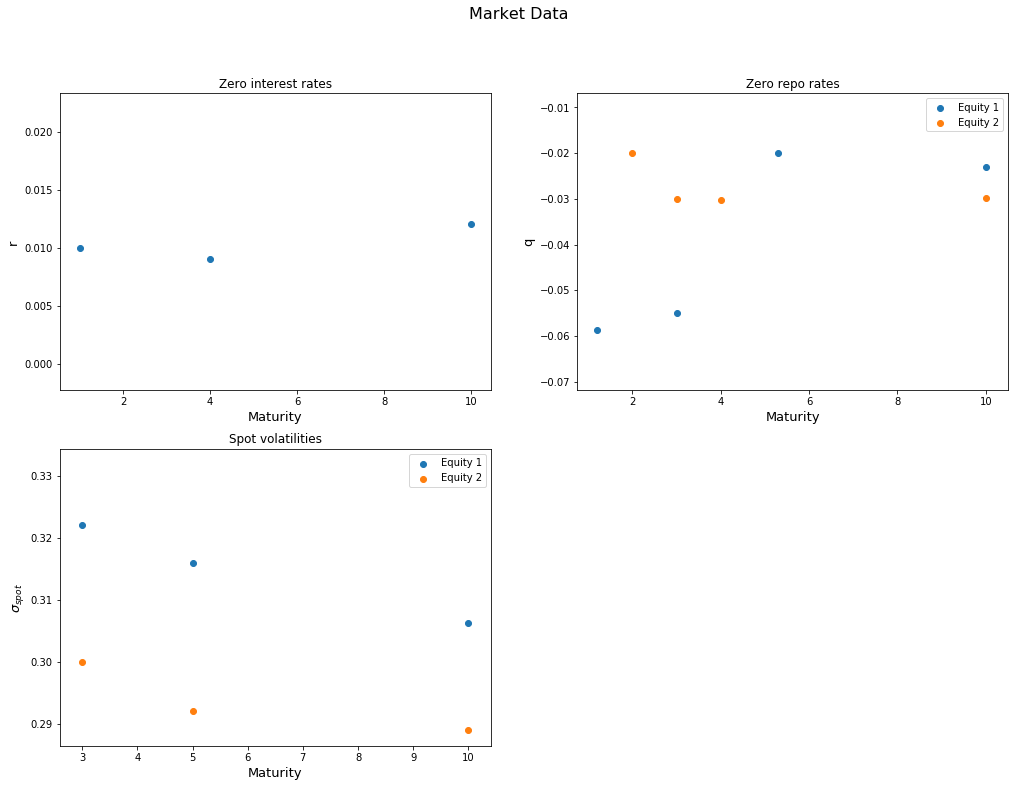

In [3]:
plt.figure(figsize=(17,12))
plt.suptitle('Market Data',fontsize=16) 

plt.subplot(2,2,1)
plt.scatter(T_discounts,r_t)
plt.title('Zero interest rates')
plt.ylabel("r", fontsize = 13)
plt.xlabel("Maturity", fontsize = 13)


plt.subplot(2,2,2)
for i in range(N_equity):
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    plt.scatter(b,a,label= "Equity "+str(i+1))
plt.legend()
plt.title('Zero repo rates')
plt.xlabel("Maturity", fontsize = 13)
plt.ylabel("q", fontsize = 13)

plt.subplot(2,2,3)
plt.title('Spot volatilities')
for i in range(N_equity):
    strikes = globals()["K" + str(i+1)]
    T = globals()["T_sigma" + str(i+1)]
    spot_volatility = globals()["spot_vola" + str(i+1)]
    spot_vol = interp1d(strikes,spot_volatility,axis=0)(spot_price[i])
    plt.scatter(T,spot_vol,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Maturity",fontsize = 13)
plt.ylabel(r"$\sigma_{spot}$",fontsize = 13)
plt.show()

#### Loading Discouting curve, Forward curve and forward variance matrix

In [4]:
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

Forward interest rate time grid [ 1.  4. 10.]
Forward interest rate:  [0.01       0.00866667 0.014     ]
Forward repo time grid [ 1.2  3.   5.3 10. ]
Forward repo rate:  [-0.05875    -0.0525      0.02565217 -0.02638298]
Forward volatility time grid:  [ 3.  5. 10.]
Forward volatility:  [0.322      0.30678005 0.2960758 ]
Forward repo time grid [ 2.  3.  4. 10.]
Forward repo rate:  [-0.02       -0.05       -0.03136    -0.02960667]
Forward volatility time grid:  [ 3.  5. 10.]
Forward volatility:  [0.3        0.2795711  0.28596853]


In [5]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)
alpha = Strategy()
alpha.Mark_strategy(mu = mu, nu = nu)

Drift time grid: [ 1.2  2.   3.   4.   5.3 10. ]
Drift values: [[-0.05875    -0.02      ]
 [-0.0525     -0.02      ]
 [-0.0525     -0.05      ]
 [ 0.02565217 -0.03136   ]
 [ 0.02565217 -0.02960671]
 [-0.02638299 -0.02960665]]
Cholesky covariance-variance time grid: [ 3.  5. 10.]
Cholesky covariance-variance matrix values: [[[0.322      0.30678005 0.2960758 ]
  [0.         0.         0.        ]]

 [[0.045      0.04193567 0.04289528]
  [0.2966058  0.27640803 0.28273308]]]
Markowitz strategy time grid : [ 1.2  2.   3.   4.   5.   5.3 10. ]
Markowitz strategy :  [[ 0.8034768   0.1965232 ]
 [ 0.77158671  0.22841329]
 [ 0.47489457  0.52510543]
 [-2.7587561   3.7587561 ]
 [-3.26581543  4.26581543]
 [-5.52996951  6.52996951]
 [ 0.44077673  0.55922327]]


/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


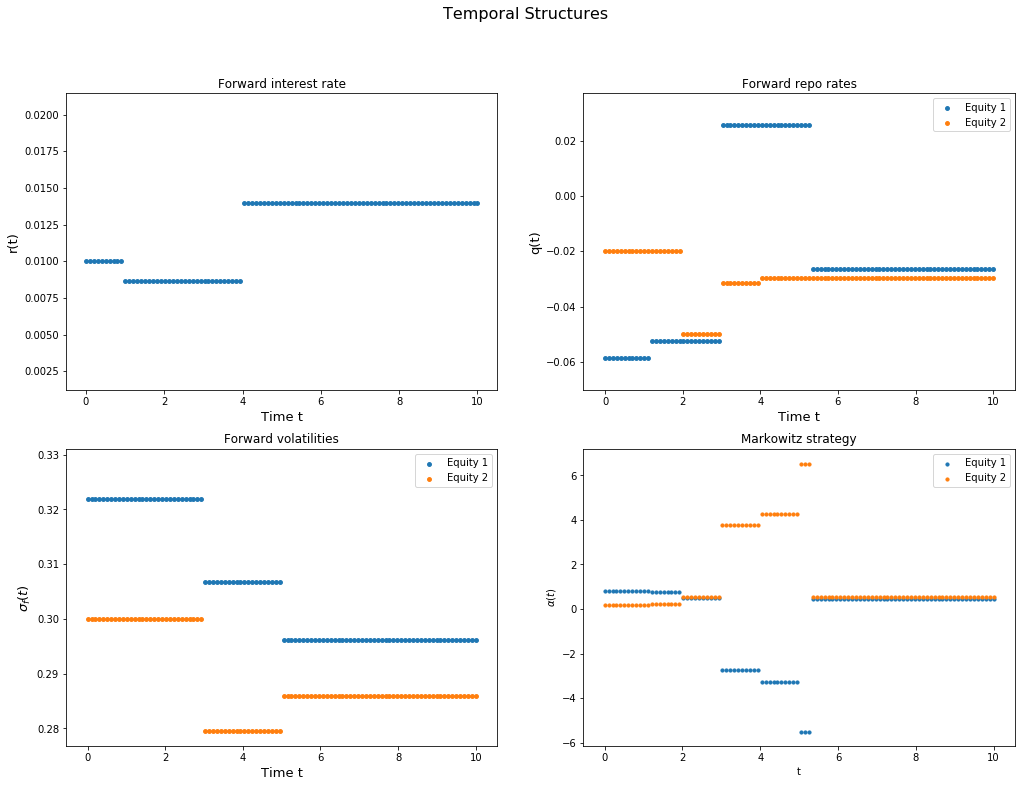

In [6]:
x = np.linspace(0,T_max-0.0001,100)
dimension_points = 15
plt.figure(figsize=(17,12))

plt.suptitle('Temporal Structures',fontsize=16) 

plt.subplot(2,2,1)
plt.scatter(x,piecewise_function(x,D.T,D.r),s=dimension_points)
plt.title('Forward interest rate')
plt.ylabel("r(t)", fontsize = 13)
plt.xlabel("Time t", fontsize = 13)


plt.subplot(2,2,2)
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,F[i].T,F[i].q),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.title('Forward repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel("q(t)", fontsize = 13)

plt.subplot(2,2,3)
plt.title('Forward volatilities')
for i in range(N_equity):
    plt.scatter(x,sqrt(V[i](x)),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{f}(t)$",fontsize = 13)

plt.subplot(2,2,4)
plt.title("Markowitz strategy")
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,alpha.T,alpha.alpha_t.T[i]),label= "Equity "+str(i+1),s=10)
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$\alpha(t)$")
plt.show()

In [7]:
I_0 = 1e5
vol = 0.25
n_dates = 40
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0
simulations = 1e6

In [8]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))

In [9]:
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_mark, result_err_mark = MC_Analisys(pay,100)

/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [10]:
alpha.Intuitive_strategy1(forward_curves=F, maturity_date=T_max)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive1, result_err_intuitive1 = MC_Analisys(pay,100)

/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Strategy time grid:  [ 0 10]
Intuitive strategy (invest all on the asset with maximum growth at maturity  [[0. 1.]
 [0. 1.]]


In [11]:
alpha.Intuitive_strategy2(mu=mu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive2, result_err_intuitive2 = MC_Analisys(pay,100)

Strategy time grid:  [ 1.2  2.   3.   4.   5.3 10. ]
Intuitive strategy (invest all on the asset with minimum mu parameter [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [12]:
alpha.Intuitive_strategy3(mu=mu,nu=nu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive3, result_err_intuitive3 = MC_Analisys(pay,100)

Strategy time grid:  [ 1.2  2.   3.   4.   5.   5.3 10. ]
Intuitive strategy (invest all on the asset with minimum mu/nu parameter [[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


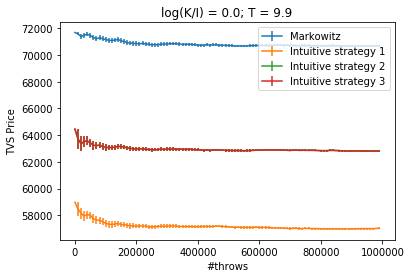

In [13]:
n =len(dates)-1
plt.title("log(K/I) = "+str(round(log(K/I_0),2))+"; T = "+str(round(dates[n],2)))
plt.errorbar(x,result_mark.T[n],yerr=result_err_mark.T[n], label = "Markowitz")
plt.errorbar(x,result_intuitive1.T[n],yerr=result_err_intuitive1.T[n],label="Intuitive strategy 1")
plt.errorbar(x,result_intuitive2.T[n],yerr=result_err_intuitive2.T[n],label="Intuitive strategy 2")
plt.errorbar(x,result_intuitive3.T[n],yerr=result_err_intuitive3.T[n],label="Intuitive strategy 3")
plt.xlabel("#throws")
plt.legend()
plt.ylabel("TVS Price")
#plt.savefig("Euler_vs_PDE_solution.pdf")
plt.show()

## Four Equities

In [14]:
N_equity = 4                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120,97,133])            #spot price of the two assets
corr = np.array(([1,0.15,0.10,0.20],[0.15,1.,-0.05,0.18],[0.1,-0.05,1.,0.13],[0.20,0.18,0.13,1]))        #correlation matrix
minus = -1
"""Market Discount factors"""
r_t = np.array([1.,0.9,1.2])/100            
T_discounts = np.array([0.1,1.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([1.2,3.,5.3,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = minus*np.array([5.875,5.50,2.,2.3])/100  #market repo rates for equity 1


T_repo2 = np.array([2.,3.,4.,T_max])
repo_rate2 = minus*np.array([2.,3.,3.034,2.99])/100

T_repo3 = np.array([1.,5.,7.5,8.93,T_max])
repo_rate3 = minus*np.array([5.67,6.7,3.034,4.5,2.99])/100

T_repo4 = np.array([0.1,3.4,7.5,8.93,T_max])
repo_rate4 = minus*np.array([1.67,2.7,3.034,2.5,2.07])/100


for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
sigma1 = np.array([32.2,29.3,29.1,29.5,29.7,29.8,29.9,30.6,30.62])/100
T_sigma1 = np.array([0.08,0.17,0.25,0.33,0.42,0.5,1.,2.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

sigma2 = np.array([35.,31.,31.,31.4,31.3,30.7,29.2,28.9,28.88])/100
T_sigma2 = np.array([0.08,0.17,0.27,0.37,0.44,0.5,1.,2.,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))  

sigma3 = np.array([25.,21.,21.,21.4,21.3,20.7,19.2,18.9,18.88])/100
T_sigma3 = np.array([0.05,0.175,0.27,0.37,0.44,0.5,1.,2.,T_max])
K3 = np.array([spot_price[2],200])
spot_vola3 = np.array((sigma3,sigma3))  

sigma4 = np.array([15.,11.,11.,11.4,11.3,10.7,9.2,8.9,8.88])/100
T_sigma4 = np.array([0.05,0.175,0.27,0.37,0.44,0.5,1.,2.,T_max])
K4 = np.array([spot_price[3],200])
spot_vola4 = np.array((sigma4,sigma4))  

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))

In [15]:
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

Forward interest rate time grid [ 0.1  1.  10. ]
Forward interest rate:  [0.01       0.00888889 0.01233333]
Forward repo time grid [ 1.2  3.   5.3 10. ]
Forward repo rate:  [-0.05875    -0.0525      0.02565217 -0.02638298]
Forward volatility time grid:  [ 0.08  0.17  0.25  0.33  0.42  0.5   1.    2.   10.  ]
Forward volatility:  [0.322      0.26456694 0.28670368 0.30716445 0.30422086 0.30319589
 0.29999667 0.31284341 0.30624998]
Forward repo time grid [ 2.  3.  4. 10.]
Forward repo rate:  [-0.02       -0.05       -0.03136    -0.02960667]
Forward volatility time grid:  [ 0.08  0.17  0.27  0.37  0.44  0.5   1.    2.   10.  ]
Forward volatility:  [0.35       0.26950572 0.31       0.32455385 0.3076603  0.25878369
 0.27618653 0.28596853 0.28874998]
Forward repo time grid [ 1.    5.    7.5   8.93 10.  ]
Forward repo rate:  [-0.0567     -0.069575    0.04298    -0.12188811  0.0961215 ]
Forward volatility time grid:  [ 0.05   0.175  0.27   0.37   0.44   0.5    1.     2.    10.   ]
Forward volat

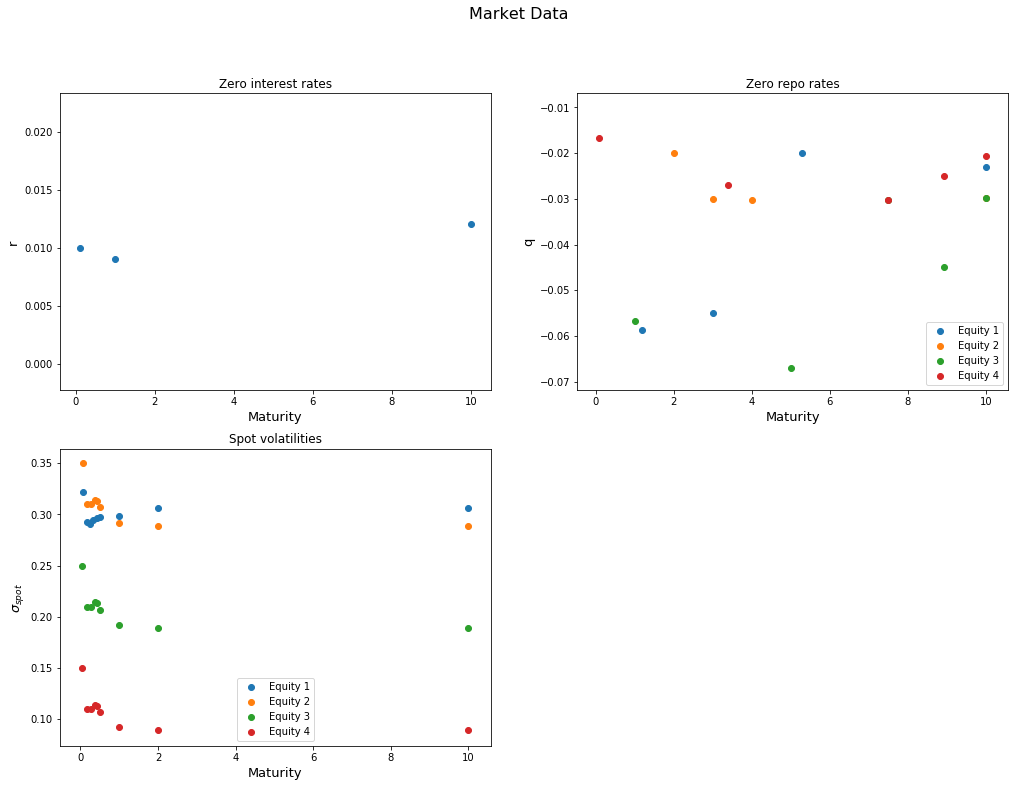

In [16]:
plt.figure(figsize=(17,12))
plt.suptitle('Market Data',fontsize=16) 

plt.subplot(2,2,1)
plt.scatter(T_discounts,r_t)
plt.title('Zero interest rates')
plt.ylabel("r", fontsize = 13)
plt.xlabel("Maturity", fontsize = 13)


plt.subplot(2,2,2)
for i in range(N_equity):
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    plt.scatter(b,a,label= "Equity "+str(i+1))
plt.legend()
plt.title('Zero repo rates')
plt.xlabel("Maturity", fontsize = 13)
plt.ylabel("q", fontsize = 13)

plt.subplot(2,2,3)
plt.title('Spot volatilities')
for i in range(N_equity):
    strikes = globals()["K" + str(i+1)]
    T = globals()["T_sigma" + str(i+1)]
    spot_volatility = globals()["spot_vola" + str(i+1)]
    spot_vol = interp1d(strikes,spot_volatility,axis=0)(spot_price[i])
    plt.scatter(T,spot_vol,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Maturity",fontsize = 13)
plt.ylabel(r"$\sigma_{spot}$",fontsize = 13)
plt.show()

In [17]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)
alpha = Strategy()
alpha.Mark_strategy(mu = mu, nu = nu)

/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Drift time grid: [ 0.1   1.    1.2   2.    3.    3.4   4.    5.    5.3   7.5   8.93 10.  ]
Drift values: [[-0.05875    -0.02       -0.0567     -0.0167    ]
 [-0.05875    -0.02       -0.0567     -0.02731212]
 [-0.05875    -0.02       -0.069575   -0.02731212]
 [-0.0525     -0.02       -0.069575   -0.02731212]
 [-0.0525     -0.05       -0.069575   -0.02731212]
 [ 0.02565218 -0.03136    -0.06957499 -0.02731212]
 [ 0.02565217 -0.03136    -0.06957501 -0.03310976]
 [ 0.02565218 -0.02960667 -0.069575   -0.03310975]
 [ 0.02565216 -0.02960687  0.04298001 -0.03310975]
 [-0.02638301 -0.02960664  0.04298    -0.03310976]
 [-0.02637866 -0.02960565 -0.12188722  0.00300697]
 [-0.02638874 -0.02960803  0.0961203   0.01518695]]
Cholesky covariance-variance time grid: [ 0.05   0.08   0.17   0.175  0.25   0.27   0.33   0.37   0.42   0.44
  0.5    1.     2.    10.   ]
Cholesky covariance-variance matrix values: [[[ 0.322       0.322       0.26456694  0.28670368  0.28670368
    0.30716445  0.30716445  0.30422

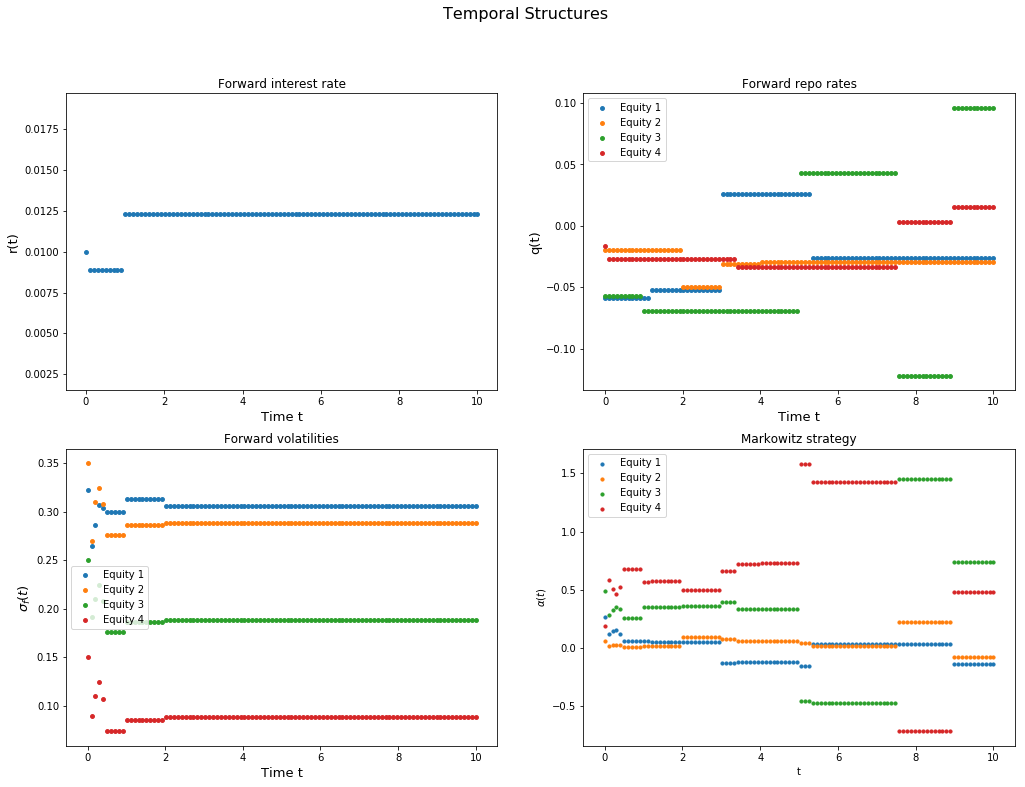

In [18]:
x = np.linspace(0,T_max-0.0001,100)
dimension_points = 15
plt.figure(figsize=(17,12))

plt.suptitle('Temporal Structures',fontsize=16) 

plt.subplot(2,2,1)
plt.scatter(x,piecewise_function(x,D.T,D.r),s=dimension_points)
plt.title('Forward interest rate')
plt.ylabel("r(t)", fontsize = 13)
plt.xlabel("Time t", fontsize = 13)


plt.subplot(2,2,2)
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,F[i].T,F[i].q),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.title('Forward repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel("q(t)", fontsize = 13)

plt.subplot(2,2,3)
plt.title('Forward volatilities')
for i in range(N_equity):
    plt.scatter(x,sqrt(V[i](x)),label= "Equity "+str(i+1),s=dimension_points)
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{f}(t)$",fontsize = 13)

plt.subplot(2,2,4)
plt.title("Markowitz strategy")
for i in range(N_equity):
    plt.scatter(x,piecewise_function(x,alpha.T,alpha.alpha_t.T[i]),label= "Equity "+str(i+1),s=10)
plt.legend()
plt.xlabel("t")
plt.ylabel(r"$\alpha(t)$")
plt.show()

In [19]:
I_0 = 1e5
vol = 0.25
n_dates = 40
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0
simulations = 1e6

In [20]:
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))

In [21]:
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_mark, result_err_mark = MC_Analisys(pay,100)

/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [22]:
alpha.Intuitive_strategy1(forward_curves=F, maturity_date=T_max)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive1, result_err_intuitive1 = MC_Analisys(pay,100)

/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Strategy time grid:  [ 0 10]
Intuitive strategy (invest all on the asset with maximum growth at maturity  [[0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [23]:
alpha.Intuitive_strategy2(mu=mu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive2, result_err_intuitive2 = MC_Analisys(pay,100)

Strategy time grid:  [ 0.1   1.    1.2   2.    3.    3.4   4.    5.    5.3   7.5   8.93 10.  ]
Intuitive strategy (invest all on the asset with minimum mu parameter [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [24]:
alpha.Intuitive_strategy3(mu=mu,nu=nu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive3, result_err_intuitive3 = MC_Analisys(pay,100)

Strategy time grid:  [ 0.05   0.08   0.1    0.17   0.175  0.25   0.27   0.33   0.37   0.42
  0.44   0.5    1.     1.2    2.     3.     3.4    4.     5.     5.3
  7.5    8.93  10.   ]
Intuitive strategy (invest all on the asset with minimum mu/nu parameter [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


/home/ste/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


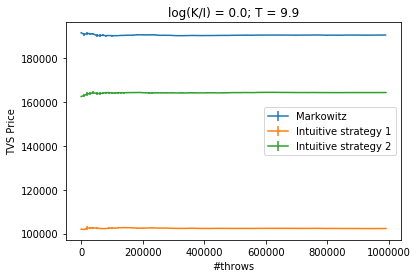

In [26]:
n =len(dates)-1
plt.title("log(K/I) = "+str(round(log(K/I_0),2))+"; T = "+str(round(dates[n],2)))
plt.errorbar(x,result_mark.T[n],yerr=result_err_mark.T[n], label = "Markowitz")
plt.errorbar(x,result_intuitive1.T[n],yerr=result_err_intuitive1.T[n],label="Intuitive strategy 1")
plt.errorbar(x,result_intuitive2.T[n],yerr=result_err_intuitive2.T[n],label="Intuitive strategy 2")
plt.errorbar(x,result_intuitive3.T[n],yerr=result_err_intuitive3.T[n],label="Intuitive strategy 3")
plt.xlabel("#throws")
plt.legend()
plt.ylabel("TVS Price")
#plt.savefig("Euler_vs_PDE_solution.pdf")
plt.show()

In [27]:
result_intuitive3.T[n]

array([162510.57629123, 162990.78095605, 163725.3004064 , 163877.09295701,
       164274.11983092, 163889.50994662, 163926.07039748, 164010.11196754,
       164291.9844309 , 164258.77334324, 164146.63348232, 164037.96247268,
       164267.06012386, 164219.15510839, 164246.2307579 , 164274.93637043,
       164298.33184386, 164305.34404467, 164317.67035392, 164358.29514082,
       164276.34094215, 164198.46274788, 164154.11255255, 164121.24452978,
       164168.11440718, 164191.0481887 , 164154.26250478, 164180.70616297,
       164159.77563519, 164187.67797566, 164169.18325356, 164131.28777277,
       164140.73661907, 164146.04750946, 164137.00993926, 164158.10125656,
       164198.06111714, 164169.77002035, 164158.77544933, 164158.96545698,
       164149.40642371, 164185.58857171, 164203.66751849, 164214.12847578,
       164160.90387327, 164160.64031821, 164185.57021421, 164206.53712339,
       164226.13458379, 164292.64371634, 164299.17194678, 164303.50540051,
       164295.23318911, 1

In [28]:
result_intuitive2.T[n]

array([162510.57629123, 162990.78095605, 163725.3004064 , 163877.09295701,
       164274.11983092, 163889.50994662, 163926.07039748, 164010.11196754,
       164291.9844309 , 164258.77334324, 164146.63348232, 164037.96247268,
       164267.06012386, 164219.15510839, 164246.2307579 , 164274.93637043,
       164298.33184386, 164305.34404467, 164317.67035392, 164358.29514082,
       164276.34094215, 164198.46274788, 164154.11255255, 164121.24452978,
       164168.11440718, 164191.0481887 , 164154.26250478, 164180.70616297,
       164159.77563519, 164187.67797566, 164169.18325356, 164131.28777277,
       164140.73661907, 164146.04750946, 164137.00993926, 164158.10125656,
       164198.06111714, 164169.77002035, 164158.77544933, 164158.96545698,
       164149.40642371, 164185.58857171, 164203.66751849, 164214.12847578,
       164160.90387327, 164160.64031821, 164185.57021421, 164206.53712339,
       164226.13458379, 164292.64371634, 164299.17194678, 164303.50540051,
       164295.23318911, 1